<a href="https://colab.research.google.com/github/Musyfy/AI_FIN_823/blob/master/LSTM_with_Hyperas_Auto_Tuning_for_stock_return_prediction_GOOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Make sure you comment out pip install hyperas after running 

In [2]:
#pip install tensorflow==1.15rc0

In [3]:
#pip install hyperas

In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import dask.dataframe as dd
import tensorflow.compat.v2 as tf
import sys

import keras as ks
from keras import backend as K
from keras import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNLSTM, CuDNNGRU, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler , MinMaxScaler, scale,Normalizer
from sklearn.model_selection import train_test_split

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle
import os
import random as rn

import pandas_datareader.data as pd_reader
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [0]:
np.random.seed(37)

# Setting the seed for python random numbers
rn.seed(1254)

# Setting the graph-level random seed.
tf.random.set_seed(42)

In [6]:
from platform import python_version
print(python_version())

3.6.9


In [7]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/


In [8]:
!ls '/gdrive/My Drive/Colab Notebooks'

'LSTM with Hyperas - Auto Tuning for stock return prediction - GOOG.ipynb'


In [9]:
## add company ticker
company = 'GOOG'
data = pd_reader.DataReader(
     '{}'.format(company),
     'yahoo')
data = data[['Adj Close','High','Open','Low','Volume']]
data["return"] = np.log(1+((data["Adj Close"]-data["Adj Close"].shift(1))/data["Adj Close"].shift(1)))
data = data.dropna()
factor_ratio = 0.7
data_1 = data.iloc[:round(len(data)*factor_ratio)]
data_2 = data[round(len(data)*factor_ratio):]
data.head()

,Adj Close,High,Open,Low,Volume,return
Date,,,,,,
2010-01-05,310.829926,312.747742,312.418976,309.609497,6031900.0,-0.004413
2010-01-06,302.994293,311.761444,311.761444,302.047852,7987100.0,-0.025532
2010-01-07,295.940735,303.861053,303.562164,295.218445,12876600.0,-0.023555
2010-01-08,299.885956,300.498657,294.894653,293.455048,9483900.0,0.013243
2010-01-11,299.432648,301.101410,301.101410,295.910858,14479800.0,-0.001513


### Make sure to edit your stock ticker in def data()

In [0]:
# ADD COMPANY TICKER
def data():
  company = 'GOOG'
  data = pd_reader.DataReader(
    '{}'.format(company),
    'yahoo')
  data = data[['Adj Close','High','Open','Low','Volume']]
  data["return"] = np.log(1+((data["Adj Close"]-data["Adj Close"].shift(1))/data["Adj Close"].shift(1)))
  data = data.dropna()
  factor_ratio = 0.7
  data_1 = data.iloc[:round(len(data)*factor_ratio)]
  data_2 = data[round(len(data)*factor_ratio):]

  ###############################################
  ##  Feature engineering construct the retrun ##
  ###############################################
  training_set = data_1.iloc[:,0:-1].values
  y_set = data_1["return"].values
  y_set = y_set.reshape(-1,1)
  sc = MinMaxScaler()
  #training_set_scaled =training_set
  
  y_set_scaled=y_set
  training_set_scaled = sc.fit_transform(training_set)
  #y_set_scaled = sc.fit_transform(y_set)

  X_train = []
  y_train = []

  for i in range(45, len(training_set_scaled)):
    X_train.append(training_set[i-45:i])
    y_train.append(y_set_scaled[i][0])

  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
  
  #test set
  y_test = data_2['return'].values

  dataset_total = data.iloc[:,0:-1]
  inputs = dataset_total[len(dataset_total) - len(data_2) -45:].values
  inputs = sc.fit_transform(inputs)

  X_test = []
  for i in range(45, len(inputs)):
    X_test.append(inputs[i-45:i])
  
  X_test, y_test = np.array(X_test), np.array(y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
  
  return X_train, y_train, X_test, y_test

In [11]:
X_train, y_train, X_test, y_test = data()
X_train.shape[1],5

(45, 5)

### Things to consider 
1. create_model function: Change epochs to a lower number in the beginning
2. create_model function: Start with lower number of layers - 4 was the best for me 
3. create_model function: The number of hidden layers is still to be tuned manually 
4. create_model function: if you are to add more layers. Make sure that the last layer is always set to (return_sequence=False) 
5. create_model function: you can add more parameters to tune: such as activation function, add more optimizers, or change dropout rate to a range between 0 & 1. 
6. if __name__ == '__main__' function: Make sure notebook_name matches the name of your notebook, otherwise it doesn't run. not sure how it would work on pycharm (you can try to remove this parameter) 
7. if __name__ == '__main__' function: you can change the number of max_eval to a lower number if you want this to run faster. This parameter is similar to a random search, and  will give you different models based on the max_eval number chosen. 3 or 4 should be okay with what I have seen so far. 

**This will take time if you are running it on your local machine**

In [0]:
def create_model(X_train, y_train, X_test, y_test): 

  """
  Model providing function:

  Create Keras model with double curly brackets dropped-in as needed.
  Return value has to be a valid python dictionary with two customary keys:
      - loss: Specify a numeric evaluation metric to be minimized
      - status: Just use STATUS_OK and see hyperopt documentation if not feasible
  The last one is optional, though recommended, namely:
      - model: specify the model just created so that we can later use it again.
  """

  model = Sequential()
  model.add(LSTM(units={{choice([100, 200, 300])}}, input_shape=(45,5),go_backwards= True, return_sequences= True))
  model.add(Dropout(rate={{uniform(0.01, 0.09)}}))
  
  model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
  model.add(Dropout(rate={{uniform(0.01, 0.09)}}))
  
  #model.add(LSTM(units={{choice([100, 200, 300])}},go_backwards= True, return_sequences= False))
  #model.add(Dropout(rate={{uniform(0.1, 0.9)}}))

  #model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
  #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
  
  #model.add(LSTM(units={{choice([100, 200, 300])}}))
  #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
  
  model.add(Dense({{choice([50, 10, 5])}}))
  model.add(Dense({{choice([50, 10,5])}}))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error',
                optimizer={{choice(['adam', 'sgd','rmsprop','adagrad'])}})

  model.summary()

  result = model.fit(X_train, y_train,
            batch_size={{choice([100,50,80])}},
            epochs=40, verbose=2)
  #get the highest validation accuracy of the training epochs
  validation_error = np.amin(result.history['loss']) 
  print('Best validation error of epoch:', validation_error)
  return {'loss': -validation_error, 'status': STATUS_OK, 'model': model}

In [13]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                    data=data,
                                    algo=tpe.suggest,
                                    max_evals=1,
                                    trials=Trials(),
                                    notebook_name= os.path.join('..','gdrive','My Drive','Colab Notebooks','LSTM with Hyperas - Auto Tuning for stock return prediction - GOOG'))
    X_train, Y_train, X_test, Y_test = data()
    print("Evalutation of best performing model:")
    print(best_model)
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    import dask.dataframe as dd
except:
    pass

try:
    import tensorflow.compat.v2 as tf
except:
    pass

try:
    import sys
except:
    pass

try:
    import keras as ks
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import metrics
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Activation, Dropout, Flatten
except:
    pass

try:
    from keras.layers.recurrent import LSTM
except:
    pass

try:
    from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDN

In [14]:
best_run

{'Dense': 2,
 'Dense_1': 1,
 'batch_size': 2,
 'optimizer': 0,
 'rate': 0.07582744887138203,
 'rate_1': 0.015229584243240595,
 'rate_2': 0.114254892109782,
 'rate_3': 0.45350896294219734,
 'rate_4': 0.38326289278437076,
 'units': 1,
 'units_1': 2,
 'units_2': 0,
 'units_3': 1,
 'units_4': 2}

In [15]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45, 200)           164800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               601200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## Make sure to edit your stock ticker again in the next cell

In [0]:
##maka sure to change the stock ticker here 
## add company ticker
company = 'GOOG'
data = pd_reader.DataReader(
     '{}'.format(company),
     'yahoo')
data = data[['Adj Close','High','Open','Low','Volume']]
data["return"] = np.log(1+((data["Adj Close"]-data["Adj Close"].shift(1))/data["Adj Close"].shift(1)))
data = data.dropna()
factor_ratio = 0.7
data_1 = data.iloc[:round(len(data)*factor_ratio)]
data_2 = data[round(len(data)*factor_ratio):]
 
training_set = data_1.iloc[:,0:-1].values
y_set = data_1["return"].values
y_set = y_set.reshape(-1,1)
sc = MinMaxScaler()
y_set_scaled = y_set
training_set_scaled = sc.fit_transform(training_set)

In [0]:
real_stock_price = data_2['return'].values

dataset_total = data.iloc[:,0:-1]
inputs = dataset_total[len(dataset_total) - len(data_2) -45:].values
inputs = sc.fit_transform(inputs)

X_test = []
for i in range(45, len(inputs)):
    X_test.append(inputs[i-45:i])

In [18]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
X_test.shape

(758, 45, 5)

In [20]:
predicted_stock_price= best_model.predict(X_test)
predicted_stock = pd.DataFrame(predicted_stock_price,columns=['perdict return'])
real_stock = pd.DataFrame(real_stock_price,columns=['real return'])
data_test = data[round(len(data)*factor_ratio):]
data_test.reset_index(inplace=True)
data_test = data_test[['Date']]

final = pd.merge(real_stock, predicted_stock, left_index=True, right_index=True)
final1 = pd.merge(data_test, final, left_index=True, right_index=True)
final1.to_csv("{}.csv".format(company))
final['direction'] = final["real return"]*final["perdict return"]
def iden(x):
    if x >0:
        return 1
    else:
        return 0
final["hit"] = final["direction"].apply(lambda x:iden(x))
print('hit ratio:{}'.format(final["hit"].sum()/final["hit"].count()))

hit ratio:0.5237467018469657


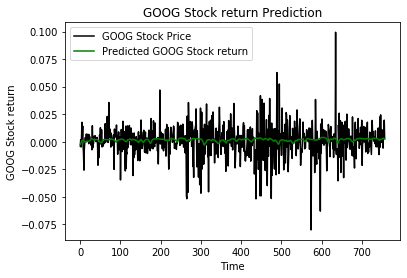

In [21]:
plt.plot(real_stock_price, color = 'black', label = '{} Stock Price'.format(company))
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted {} Stock return'.format(company))
plt.title('{} Stock return Prediction'.format(company))
plt.xlabel('Time')
plt.ylabel('{} Stock return'.format(company))
plt.legend()
plt.show()

In [0]:
import pickle
with open('GOOG_model.pickle','wb') as f:
    pickle.dump(best_model,f)

with open('GOOG_model.pickle','rb') as f:
    model = pickle.load(f)

In [0]:
from google.colab import files
#files.download('GOOG_model.pickle') 
files.download("GOOG.csv")